# Flood Exposure Analysis

In [10]:
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from folium.raster_layers import ImageOverlay
from folium.plugins import MarkerCluster
import folium
import pandas as pd
from geopy.distance import geodesic


### 1. Load the flood projection model map

Data range: Min = -9999.0, Max = 0.5814733505249023


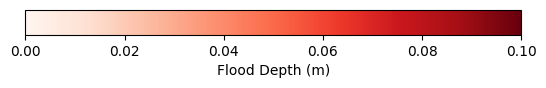

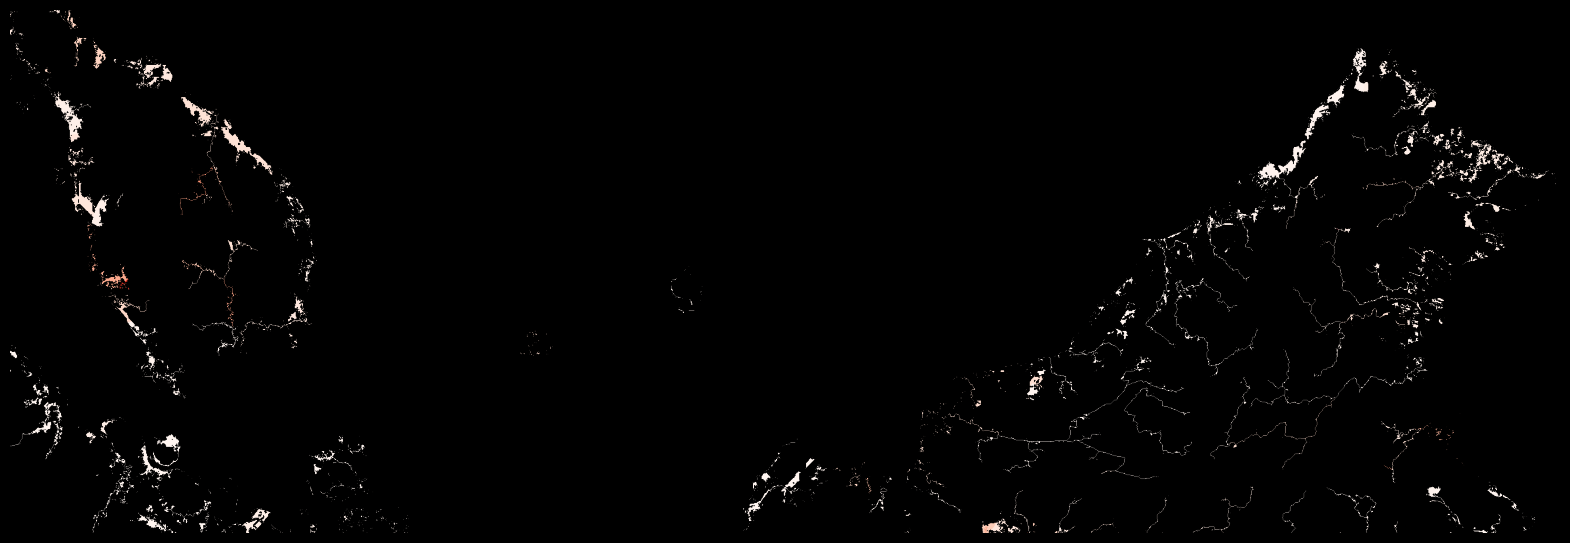

In [11]:

# Define the bounding box for Malaysia
malaysia_bbox = {
    "left": 99.60,  # Longitude of the left (west) boundary
    "bottom": 0.85,  # Latitude of the bottom (south) boundary
    "right": 119.30,  # Longitude of the right (east) boundary
    "top": 7.50,  # Latitude of the top (north) boundary
}

# Open the GeoTIFF file
tiff_file = r"C:\Users\ibrah\OneDrive\Documents\Projects\Exploration\geospatial\data\projection\inunriver_rcp4p5_00000NorESM1-M_2030_rp00002.tif"

with rasterio.open(tiff_file) as dataset:
    # Convert the bounding box to pixel coordinates (window)
    window = from_bounds(
        malaysia_bbox["left"],
        malaysia_bbox["bottom"],
        malaysia_bbox["right"],
        malaysia_bbox["top"],
        transform=dataset.transform,
    )

    # Read the windowed data
    window_data = dataset.read(1, window=window)

    # Check the range of values to better understand the data
    min_value = np.min(window_data)
    max_value = np.max(window_data)
    print(f"Data range: Min = {min_value}, Max = {max_value}")

    # Adjust the range for visualization (e.g., focus on depths between 0-10 meters)
    vmin, vmax = (
        0,
        0.1,
    )

    # Mask out no-data areas or irrelevant data (e.g., ocean, null values)
    # Irrelevant area is marked as -9999, whereas no flood is marked as 0. So we masked those value from 0 or less.
    masked_data = np.ma.masked_where(
        window_data <= 0, window_data
    ) 

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Use the Blues color map (goes from light blue to dard blue)
    cax = ax.imshow(masked_data, cmap='Reds', vmin=vmin, vmax=vmax)
    ax.set_visible(False)
    cbar = fig.colorbar(cax, orientation='horizontal')
    cbar.set_label("Flood Depth (m)")
    plt.show()

    # Save the image to overlay with other maps
    plt.imsave("flood_projection.png", masked_data, cmap='Reds')
    plt.close()

    # show the saved image
    flood_proj_img = mpimg.imread('flood_projection.png')
    # Create a figure with a specified size (in inches)
    fig, ax = plt.subplots(figsize=(10*2, 8*2), facecolor='black')
    ax.imshow(flood_proj_img)
    # ax.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()
    


### 2. Marked Office and Client Location

In [12]:
# Load the clients geodata
client_data_path = ( r"C:\Users\ibrah\OneDrive\Documents\Projects\Exploration\geospatial\data\data.xlsx")
client_df = pd.read_excel(client_data_path, sheet_name="Sheet1")

# Add client's longitude and latitude
client_df[["Latitude", "Longitude"]] = (
    client_df["Coordinate"].str.split(", ", expand=True).astype(float)
)

# Coordinates for Menara Takaful Malaysia (Office)
office_longitude = 101.69612
office_latitude = 3.13935

# Initialize the map centered around Kuala Lumpur with a starting zoom level
m = folium.Map(location=[office_latitude, office_longitude], zoom_start=14, tiles="OpenStreetMap")



# Add the office location marker
folium.Marker(
    [office_latitude, office_longitude],
    popup="Menara Takaful Malaysia",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(m)

client_layer = folium.FeatureGroup(name="Client Location").add_to(m)

# Add client locations and highlight those within 500m of a flood point
for i, client_row in client_df.iterrows():
    client_location = (client_row["Latitude"], client_row["Longitude"])
    client_within_flood_radius = False

    folium.Marker(
        location=[client_row["Latitude"], client_row["Longitude"]],
        popup=f"Client Location: {client_row['Branch Name']}",
        icon=folium.Icon(
            color="orange", icon="info-sign"
        ),
    ).add_to(client_layer)

# Save the map with the time slider and markers
m.save("map_wClients.html")
m

### 3.  Highlight main river lines in Kuala Lumpur for better visualisation

In [13]:
# Adding highlights to main river
gombak_river_geojson = r"C:\Users\ibrah\OneDrive\Documents\Projects\Exploration\geospatial\data\river\gombak.geojson"
klang_river_geojson = r"C:\Users\ibrah\OneDrive\Documents\Projects\Exploration\geospatial\data\river\klang.geojson"
batu_river_geojson = r"C:\Users\ibrah\OneDrive\Documents\Projects\Exploration\geospatial\data\river\batu.geojson"

folium.GeoJson(
    gombak_river_geojson,
    name="Gombak River",
    style_function=lambda x: {
        "color": "purple",
        "weight": 5,
        "fillColor": "cyan",
        "fillOpacity": 0.3,
    },
).add_to(m)

folium.GeoJson(
    klang_river_geojson,
    name="Klang River",
    style_function=lambda x: {
        "color": "purple",
        "weight": 5,
        "fillColor": "cyan",
        "fillOpacity": 0.3,
    },
).add_to(m)

folium.GeoJson(
    batu_river_geojson,
    name="Batu River",
    style_function=lambda x: {
        "color": "purple",
        "weight": 5,
        "fillColor": "cyan",
        "fillOpacity": 0.3,
    },
).add_to(m)

m.save("map_wClients_wRiver.html")
m


### 4. Overlay flood projection map with client point map


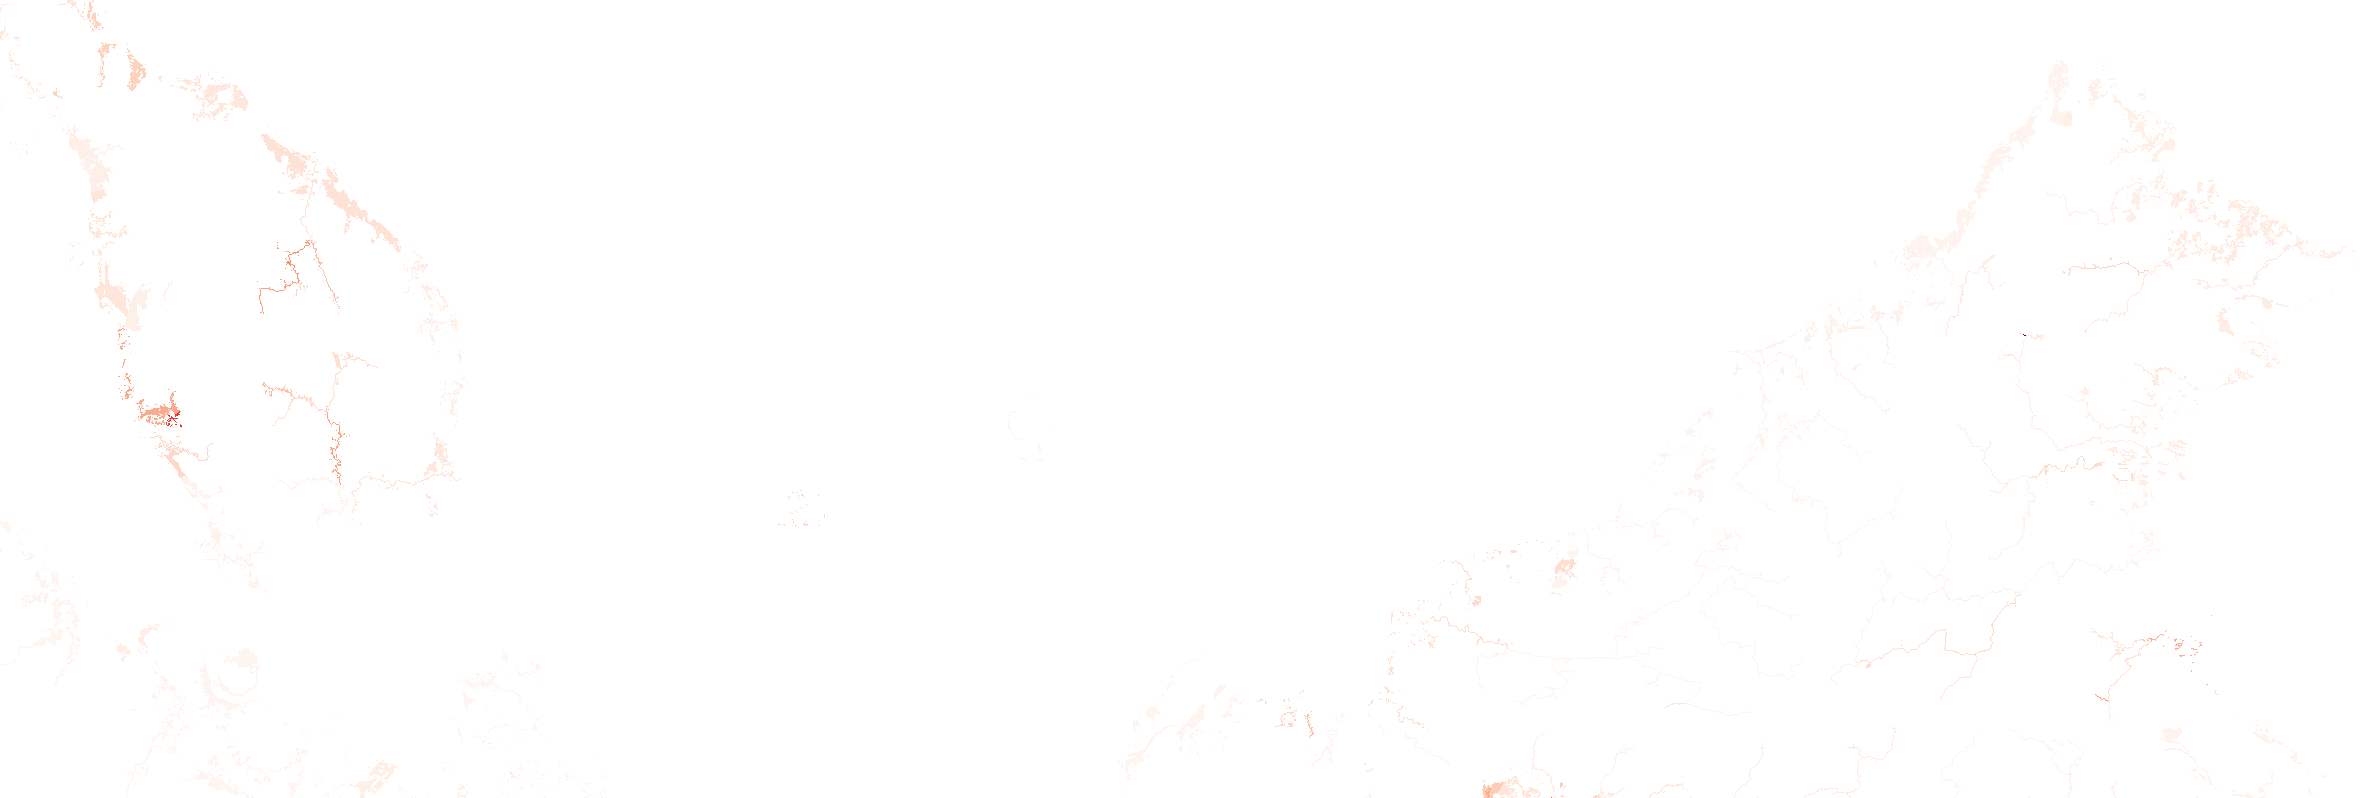

In [14]:

# Add the overlay (ImageOverlay) to the map using the geographic bounds
bounds = [
    [malaysia_bbox["bottom"], malaysia_bbox["left"]],
    [malaysia_bbox["top"], malaysia_bbox["right"]],
]

ImageOverlay(
    image="flood_projection.png",
    bounds=bounds,  # [[south, west], [north, east]] of the image
    opacity=0.7,  # Lower opacity for better map visibility
    name="Flood Model 1"
).add_to(m)

# Add layer control to toggle layers - this should be the last point after adding all the layers we want
# folium.LayerControl().add_to(m)

# Save the map with the overlay as an HTML file
m.save("map_wClients_wRiver_wFlood.html")
m


### 5. Add historical flood point to the map


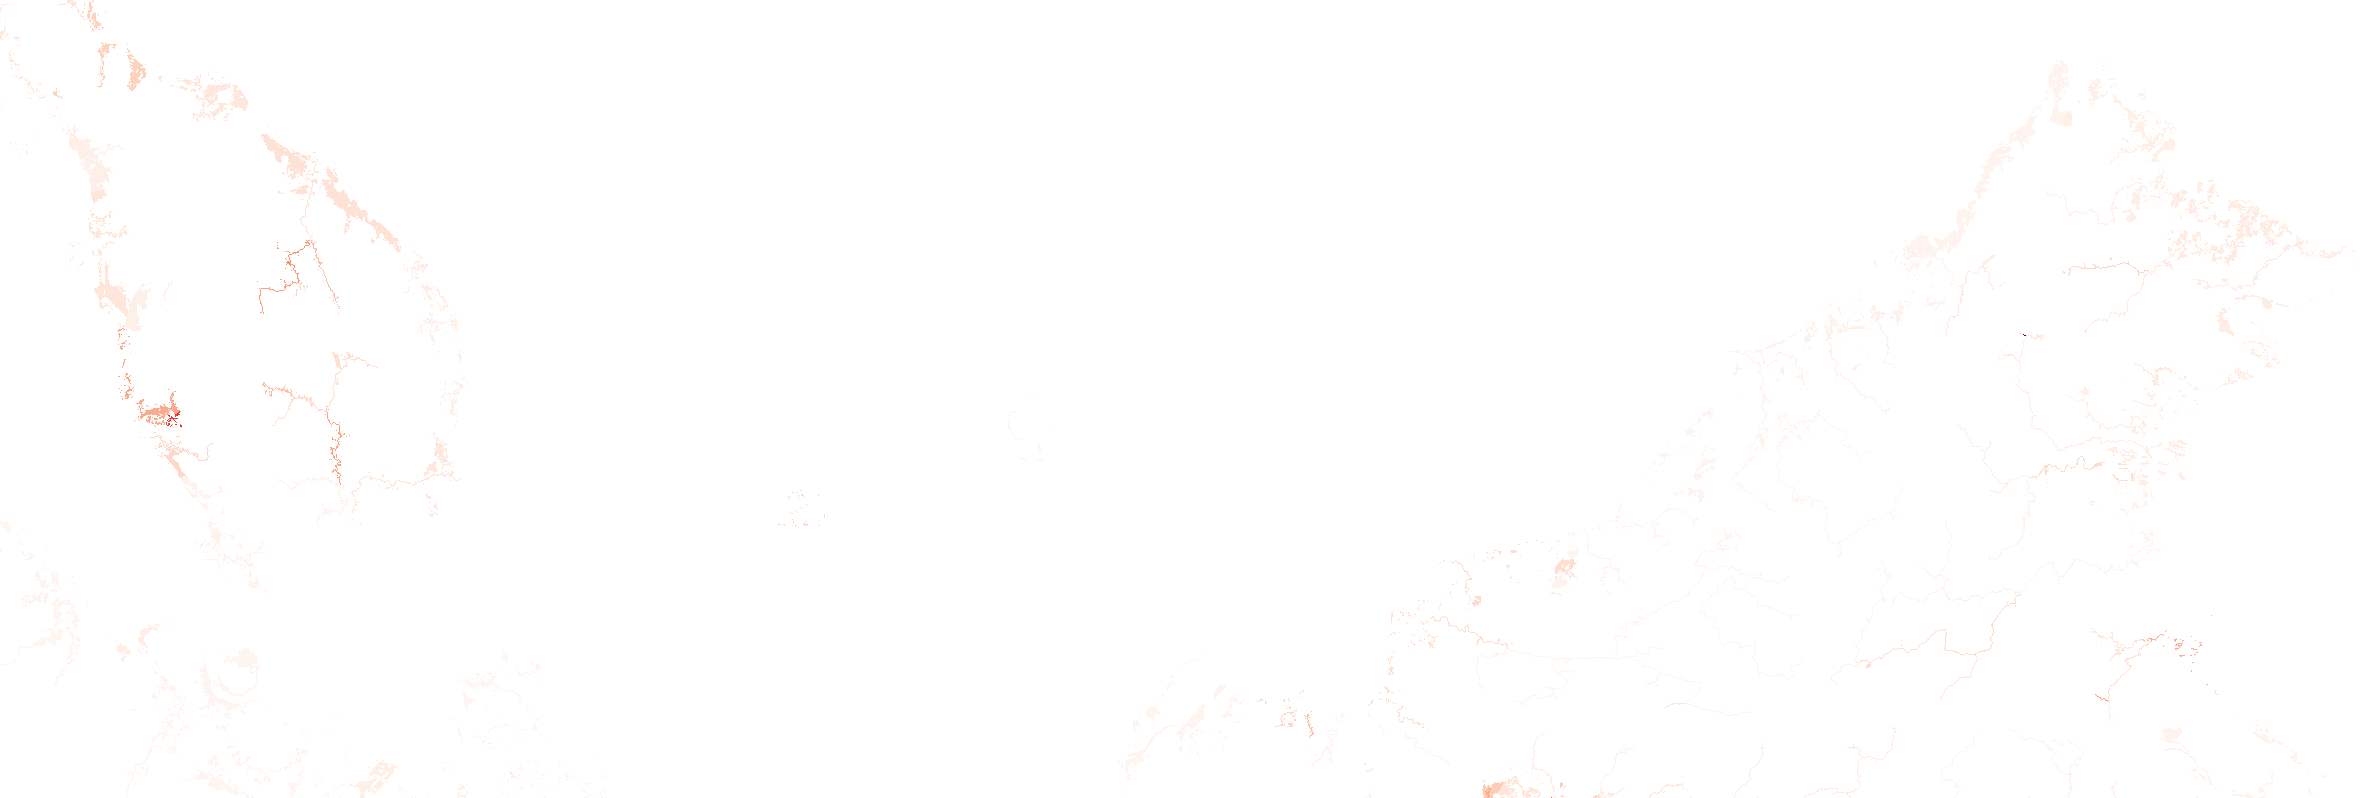

In [15]:
# Load the flood incidence data from the Excel file
flood_data_path = r"C:\Users\ibrah\OneDrive\Documents\Projects\Exploration\geospatial\data\flood_incidence_kuala_lumpur_expanded.xlsx"
flood_df = pd.read_excel(flood_data_path, sheet_name="Sheet1")

# Create a feature group to control both markers and circles
flood_layer = folium.FeatureGroup(name="Flood Points").add_to(m)
marker_cluster = MarkerCluster().add_to(flood_layer)

# Add flood points and x-meter radius circles
for i, row in flood_df.iterrows():
    
    # Add flood point marker
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"Location: {row['Location']}, Flood Year: {row['Year']}",
        icon=folium.Icon(color='blue', icon="cloud"),
        name="Historical Flood Point",
    ).add_to(marker_cluster)

    # Add x-meter radius circle around the flood point
    folium.Circle(
        location=[row["Latitude"], row["Longitude"]],
        radius=200,  # in meters
        color='blue',
        fill=True,
        fill_opacity=0.1,
    ).add_to(flood_layer)

# folium.LayerControl().add_to(m)
m

#### - Highlight client within 100m radius of historical flood point

Location that falls within 100m of flood point.
['Jalan Tun H.S. Lee,92, Jalan Tun H.S. Lee, Kuala Lumpur', 'Taman Cheras Makmur,Jalan Kaskas 1, Batu 6, Jalan Cheras, Kuala Lumpur']



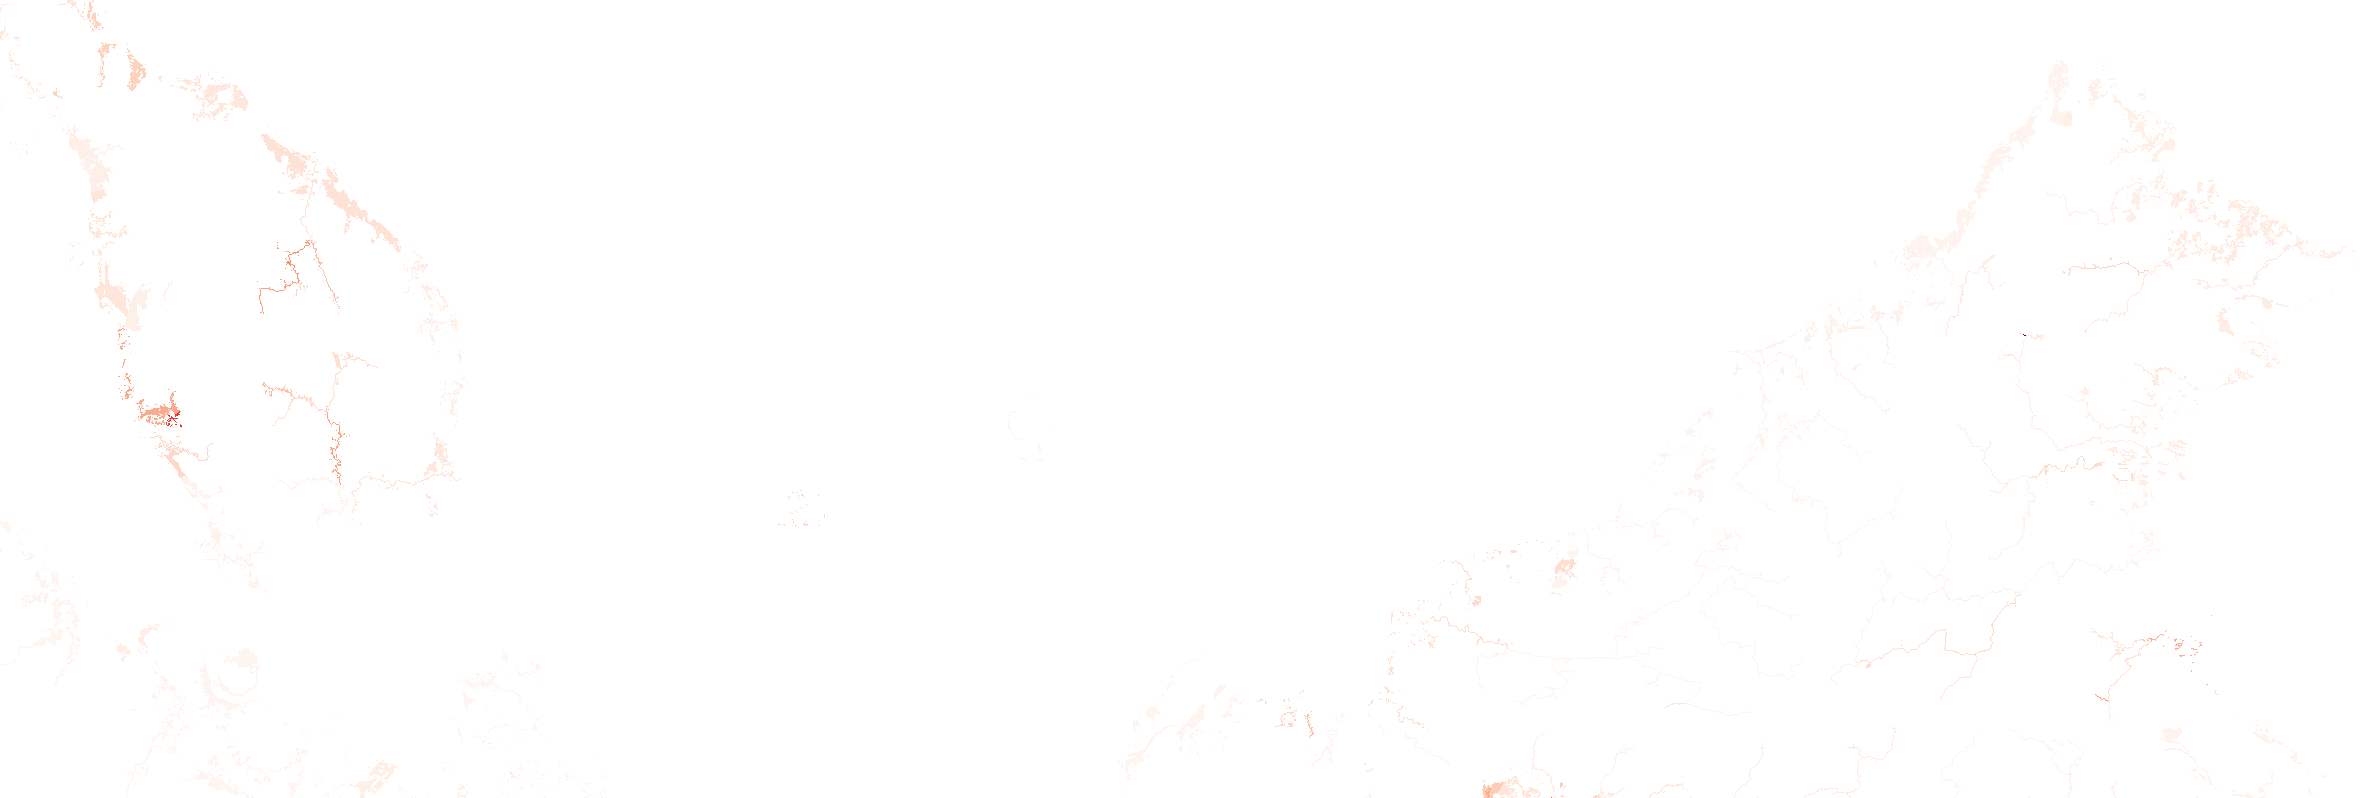

In [16]:
# Function to check if a client falls within x meters of a flood point
def is_within_radius(flood_point, client_point, radius=200):
    distance = geodesic(flood_point, client_point).meters
    return distance <= radius


# Add client locations and highlight those within x meters of a flood point
client_layer_highlight = folium.FeatureGroup(name="Client Location Highlight Within").add_to(m)
affected_loc = []

for i, client_row in client_df.iterrows():
    client_location = (client_row["Latitude"], client_row["Longitude"])
    client_within_flood_radius = False

    for j, flood_row in flood_df.iterrows():
        flood_location = (flood_row["Latitude"], flood_row["Longitude"])
        if is_within_radius(flood_location, client_location):
            client_within_flood_radius = True
            affected_loc.append(client_row['Branch Name'])
            break

    # Use yellow for clients within flood radius, otherwise orange
    marker_color = "purple" if client_within_flood_radius else "orange"

    folium.Marker(
        location=[client_row["Latitude"], client_row["Longitude"]],
        popup=f"Client Location: {client_row['Branch Name']}",
        icon=folium.Icon(
            color=marker_color, icon="info-sign"
        ),
    ).add_to(client_layer_highlight)

print("Location that falls within 100m of flood point.")
print(affected_loc)
folium.LayerControl().add_to(m)

# Save the map with the overlay as an HTML file
m.save("map_wClients_wRiver_wFlood.html")
m

#### - Finding client location that falls within the historical flood data 

In [17]:
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Create GeoDataFrame for Flood Points
flood_gdf = gpd.GeoDataFrame(
    flood_df, 
    geometry=gpd.points_from_xy(flood_df['Longitude'], flood_df['Latitude']),
    crs="EPSG:4326"  # Use WGS 84 coordinate system
)

# Step 2: Create GeoDataFrame for Client Points
client_gdf = gpd.GeoDataFrame(
    client_df, 
    geometry=gpd.points_from_xy(client_df['Longitude'], client_df['Latitude']),
    crs="EPSG:4326"  # Use WGS 84 coordinate system
)

# Step 3: Reproject to a coordinate system that uses meters (UTM Zone 47N for Malaysia)
flood_gdf = flood_gdf.to_crs(epsg=32647)  # UTM zone 47N for Malaysia
client_gdf = client_gdf.to_crs(epsg=32647)

# Step 4: Add 200-meter radius buffer around each flood point
flood_gdf['geometry'] = flood_gdf.buffer(200)  

# Step 5: Perform spatial join to find which clients fall within the 100-meter flood buffers
result = gpd.sjoin(client_gdf, flood_gdf, how='inner', predicate='within')

# Step 6: Save the result to Excel
result.to_excel('clients_within_flood_points.xlsx', index=False)

# Optional: Inspect the result
result.head()

,Branch Name,Coordinate,Latitude_left,Longitude_left,geometry,index_right,Location,Latitude_right,Longitude_right,Year
0,"Jalan Tun H.S. Lee,92, Jalan Tun H.S. Lee, Kua...","3.147265049934436, 101.69671755349766",3.147265,101.696718,POINT (799738.33 348258.353),9,d) Lebuh Ampang,3.1490,101.6971,2020
0,"Jalan Tun H.S. Lee,92, Jalan Tun H.S. Lee, Kua...","3.147265049934436, 101.69671755349766",3.147265,101.696718,POINT (799738.33 348258.353),77,Lebuh Ampang,3.1489,101.6972,2021
11,"Taman Cheras Makmur,Jalan Kaskas 1, Batu 6, Ja...","3.1003436413488834, 101.74069270324374",3.100344,101.740693,POINT (804643.386 343078.782),22,a) Hospital Pantai Cheras,3.1020,101.7410,2020
11,"Taman Cheras Makmur,Jalan Kaskas 1, Batu 6, Ja...","3.1003436413488834, 101.74069270324374",3.100344,101.740693,POINT (804643.386 343078.782),66,"KUALA LUMPUR \nLorong Lobak,",3.1016,101.7417,2021
11,"Taman Cheras Makmur,Jalan Kaskas 1, Batu 6, Ja...","3.1003436413488834, 101.74069270324374",3.100344,101.740693,POINT (804643.386 343078.782),67,"Jalan Kaskas,",3.1012,101.7421,2021


#### - Finding client that falls within the projected flood area

In [18]:
import geopandas as gpd
import rasterio
from rasterstats import point_query
import pandas as pd

# Step 1: Load the GeoTIFF file using rasterio
raster = rasterio.open(tiff_file)

# Step 2: Load the client points using GeoPandas
client_gdf = gpd.GeoDataFrame(
    client_df, 
    geometry=gpd.points_from_xy(client_df['Longitude'], client_df['Latitude']),
    crs="EPSG:4326"  # Assuming your data uses WGS 84
)

# Step 3: Reproject the client points to match the CRS of the GeoTIFF (if necessary)
# Check if the CRS matches
if client_gdf.crs != raster.crs:
    client_gdf = client_gdf.to_crs(raster.crs)

# Step 4: Extract the raster values at each client point using point_query
# This will give you the pixel value (or None if outside the raster)
client_gdf['raster_value'] = point_query(client_gdf.geometry, tiff_file)

# Step 5: Filter based on raster value if needed (e.g., exclude None or certain values)
# For example, if you want to exclude points that fall outside the area marked by the GeoTIFF
client_gdf_filtered = client_gdf[
    (client_gdf['raster_value'].notna()) &  # Not null values
    (client_gdf['raster_value'] != -9999) &  # Exclude -9999 (not applicable)
    (client_gdf['raster_value'] != 0)]        # Exclude 0 (non-flooded)

# Step 6: Save the result to Excel
client_gdf_filtered.to_excel('clients_with_raster_data.xlsx', index=False)

# Optional: Inspect the result
print(client_gdf_filtered.head())


                   Branch Name                              Coordinate  \
25  Puncak Alam Industrial Hub  3.2380822760039814, 101.45890444420722   

    Latitude   Longitude                  geometry  raster_value  
25  3.238082  101.458904  POINT (101.4589 3.23808)       0.00632  
